In [291]:
# Data handling
import pandas as pd
import numpy as np
import networkx as nx

# Machine Learning
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor, plot_importance
import giotto as go
import giotto.time_series as ts
import giotto.graphs as gr
import giotto.diagrams as diag
import giotto.homology as hl

# Plotting functions
import matplotlib.pyplot as plt
import seaborn as sns
from plotting import plot_diagram, plot_landscapes
from plotting import plot_betti_surfaces, plot_betti_curves
from plotting import plot_point_cloud
from xgboost import plot_importance


# Others
import os
from itertools import product
import time

In [228]:
def score(y_true, y_pred, types):
    score = [] 
    for t in np.unique(types):
        score.append(np.log(mean_absolute_error(y_pred[types==t], y_true[types==t])))
    score = 1./len(np.unique(types)) * np.sum(score)
    return score

def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [3]:
file_folder = '../data/champs-scalar-coupling' if 'champs-scalar-coupling' in os.listdir('../data/') else '../data'
os.listdir(file_folder)

['scalar_coupling_contributions.csv',
 '.DS_Store',
 'mulliken_charges.csv',
 'structures',
 'structures.csv',
 'test.csv',
 '.gitkeep',
 'structures.zip',
 'train.csv',
 'magnetic_shielding_tensors.csv',
 'dipole_moments.csv',
 'sample_submission.csv',
 'potential_energy.csv']

In [4]:
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
sub = pd.read_csv(f'{file_folder}/sample_submission.csv')
structures = pd.read_csv(f'{file_folder}/structures.csv')

In [5]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [6]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

In [7]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])
train['type_1'] = train['type'].apply(lambda x: x[1:])
test['type_1'] = test['type'].apply(lambda x: x[1:])

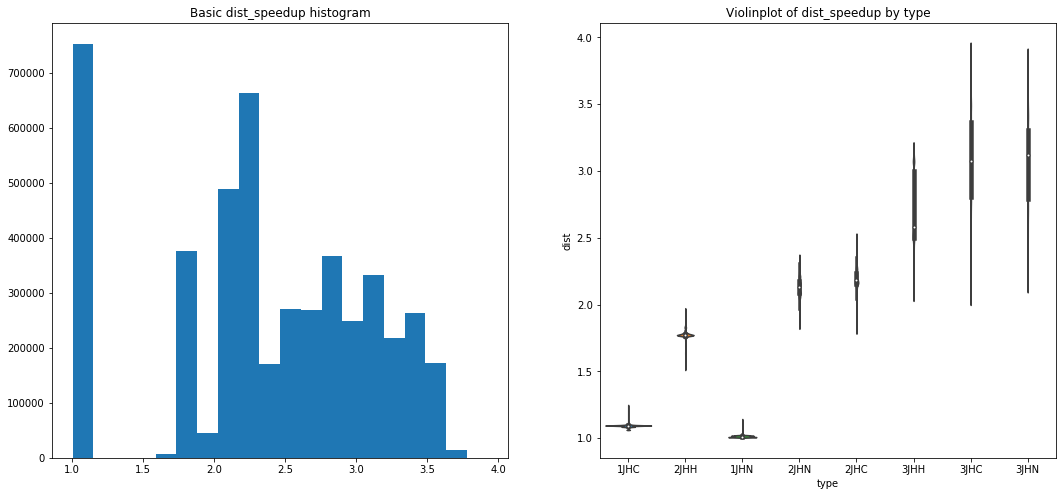

In [8]:
fig, ax = plt.subplots(figsize = (18, 8))
plt.subplot(1, 2, 1);
plt.hist(train['dist'], bins=20);
plt.title('Basic dist_speedup histogram');
plt.subplot(1, 2, 2);
sns.violinplot(x='type', y='dist', data=train);
plt.title('Violinplot of dist_speedup by type');

In [9]:
train['dist_to_type_mean'] = train['dist'] / train.groupby('type')['dist'].transform('mean')
test['dist_to_type_mean'] = test['dist'] / test.groupby('type')['dist'].transform('mean')

train['dist_to_type_0_mean'] = train['dist'] / train.groupby('type_0')['dist'].transform('mean')
test['dist_to_type_0_mean'] = test['dist'] / test.groupby('type_0')['dist'].transform('mean')

train['dist_to_type_1_mean'] = train['dist'] / train.groupby('type_1')['dist'].transform('mean')
test['dist_to_type_1_mean'] = test['dist'] / test.groupby('type_1')['dist'].transform('mean')

In [10]:
train[f'molecule_type_dist_mean'] = train.groupby(['molecule_name', 'type'])['dist'].transform('mean')
test[f'molecule_type_dist_mean'] = test.groupby(['molecule_name', 'type'])['dist'].transform('mean')

In [11]:
for f in ['atom_0', 'atom_1', 'type_0', 'type_1', 'type']:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [39]:
X = train.drop(['id', 'molecule_name', 'scalar_coupling_constant'], axis=1).loc[:10000]
y = train['scalar_coupling_constant'].loc[:10000]

## Naive Model

In [239]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'reg:squarederror',
          'max_depth': 13,
          'learning_rate': 0.1,
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": 1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

model = XGBRegressor(**params)
#model = RandomForestRegressor(max_depth=100)

n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=43)

results = []

for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    print(group_mean_log_mae(y_pred, y_valid, X_valid['type']))
    results.append(group_mean_log_mae(y_pred, y_valid, X_valid['type']))
    
print(np.mean(results), np.std(results))

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



0.4335839549691009
0.47627978003051796
0.5940161863797733
0.4246975835572923
0.4887941965145671
0.48347434029025027 0.0604041720148471


## Better baseline

In [243]:
def get_number_of_atoms(g):
    return len(g)
molecule_selection = train.groupby(by='molecule_name').apply(get_number_of_atoms).nlargest(100)

In [255]:
# Import 
train_dist = pd.read_csv('/Users/colinkalin/Desktop/train_dist.csv')

In [256]:
train_dist.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'type_0', 'type_1', 'atom_0', 'x_0', 'y_0',
       'z_0', 'atom_1', 'x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y',
       'dist_z', 'dist_to_type_mean', 'dist_to_type_0_mean',
       'dist_to_type_1_mean', 'molecule_dist_mean_x', 'molecule_dist_std_x',
       'molecule_dist_skew_x', 'molecule_dist_kurt_x', 'molecule_dist_mean_y',
       'molecule_dist_std_y', 'molecule_dist_skew_y', 'molecule_dist_kurt_y',
       'meanx', 'meany', 'meanz', 'dist_0tomean', 'dist_1tomean', 'meanxH',
       'meanyH', 'meanzH', 'dist_0tomeanH', 'dist_1tomeanH', 'meanxC',
       'meanyC', 'meanzC', 'dist_0tomeanC', 'dist_1tomeanC', 'meanxN',
       'meanyN', 'meanzN', 'dist_0tomeanN', 'dist_1tomeanN', 'meanxO',
       'meanyO', 'meanzO', 'dist_0tomeanO', 'dist_1tomeanO', 'meanxF',
       'meanyF', 'meanzF', 'dist_0tomeanF', 'dist_1tomeanF', 'atom_count',
       'atom_0l', 'x_0l', 'y_0l', 'z_0l', 'atom_

In [296]:
X = train_dist[train_dist['molecule_name'].isin(molecule_selection.index)].reset_index()
y = X['scalar_coupling_constant']
X.drop(['id', 'molecule_name', 'scalar_coupling_constant'], axis='columns', inplace=True)


lenc = LabelEncoder()
lenc.fit(X['atom_1'])
X['atom_0'] = lenc.transform(X['atom_0'])
X['atom_1'] = lenc.transform(X['atom_1'])

X.drop('index', axis='columns', inplace=True)

In [297]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'reg:squarederror',
          'max_depth': 13,
          'learning_rate': 0.1,
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": 1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

model = XGBRegressor(**params)

n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=43)

results = []

for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    print(group_mean_log_mae(y_pred, y_valid, X_valid['type']))
    results.append(group_mean_log_mae(y_pred, y_valid, X_valid['type']))
    
print(np.mean(results), np.std(results))

-0.8227039877117939
-0.8731179430381525
-0.834635523688331
-0.7536559896267269
-0.7535808998791302
-0.807538868788827 0.047073669059775614


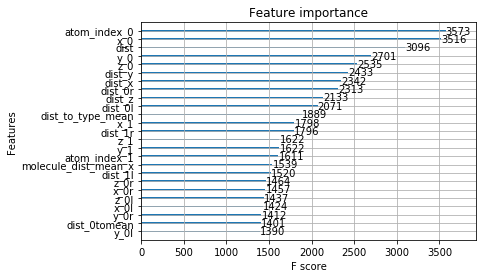

In [304]:
plot_importance(model, max_num_features=25)